In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os.path as path
import os

In [2]:
plt.style.use('default')

In [3]:
def plot_thrpt(data, x_col, lines_cols, mapper=lambda x: x, nc=3):
    data = data[~data["DSU"].str.contains(':')]
    data = mapper(data).copy()
    
    if type(lines_cols) != list:
        lines_cols = [lines_cols]
    params = data.columns.drop(["Score", "Score Error", x_col] + lines_cols)
    unique_index = data[params].drop_duplicates()
    
    n = (len(unique_index) + nc-1) // nc
    if n == 0:
        fig, ax = plt.subplots(figsize=(8,6), ncols=1, nrows=1)
        ax = list(ax)
    else:
        fig, ax = plt.subplots(figsize=(8*nc, 6 * n), ncols=nc, nrows=n)
        ax = list(ax.flat)

    for _, index in unique_index.iterrows():
        plt.sca(ax[0])
        ax = ax[1:]
        
        ttl = ''
        for i, c in enumerate(unique_index.columns):
            if ttl != '':
                ttl += ', '
            ttl += c + '=' + str(index[i])
        plt.title(ttl)
        
        fig_data = data[(data[unique_index.columns] == index).all(axis=1)]
        lines_index = fig_data[lines_cols].drop_duplicates()
        
        for _, l_index in lines_index.iterrows():
            lbl = ', '.join(map(str, l_index))
            line_data = fig_data[(fig_data[lines_cols] == l_index).all(axis=1)]
            x = line_data[x_col]
            y = line_data["Score"]
            e = line_data["Score Error"]
            l = plt.errorbar(x, y, yerr=e, capsize=3, label=lbl)
        if x_col == 'ssf':
            plt.xlabel("Same Set requests fraction")
        else:
            plt.xlabel(x_col)
        plt.ylabel("Throughput (ops/s)")
#         y_min, y_max = plt.ylim()
#         plt.ylim(2.5e6, 5.5e6)
        plt.legend()
        plt.grid()
    plt.suptitle("Throughput")

In [4]:
def get_hist(iBegin, iEnd, metric, data):
    data = data[(data["index"] >= iBegin) & (data["index"] < iEnd)]
    data = data[data["metric"] == metric]
    by_index = list(list(zip(*list(data.groupby("index"))))[1])
    # by_point = list(data.groupby("point"))
    max_point = data["point"].max()
    res = []
    for i in range(0, max_point + 1):
        s = data[data["point"] == i]["value"].sum()
        c = len(by_index)
        res.append(s / c)
    return pd.Series(res, name=metric)

In [5]:
def plot_hist(data, h_data, metric, lines_cols, mapper=lambda x: x, nc=3):
    data = data[data["DSU"].str.endswith(':hist_begin') | data["DSU"].str.endswith(':hist_end')]
    data = mapper(data).copy()
    data["Begin"] = data["DSU"].str.endswith(':hist_begin')
    data["DSU"] = data["DSU"].apply(lambda s: s[:s.index(':')])
    
    if type(lines_cols) != list:
        lines_cols = [lines_cols]
    params = data.columns.drop(["Score", "Score Error", "Begin"] + lines_cols)
    unique_index = data[params].drop_duplicates()
    
    n = (len(unique_index) + nc - 1) // nc
    if len(unique_index) == 1:
        fig, ax = plt.subplots(figsize=(8,6), ncols=1, nrows=1)
        ax = [ax]
    else:
        fig, ax = plt.subplots(figsize=(8 * nc, 6 * n), ncols=nc, nrows=n)
        ax = list(ax.flat)

    for _, index in unique_index.iterrows():
        plt.sca(ax[0])
        ax = ax[1:]
        
        ttl = ''
        for i, c in enumerate(unique_index.columns):
            if ttl != '':
                ttl += ', '
            ttl += c + '=' + str(index[i])
        plt.title(ttl)
        
        fig_data = data[(data[unique_index.columns] == index).all(axis=1)]
        lines_index = fig_data[lines_cols].drop_duplicates()
        
        k = len(lines_index)
        k_start = -0.4 + (0.4 / k)
        k_step = 0.8 / k
        maxl = 0
        for _, l_index in lines_index.iterrows():
            lbl = ', '.join(map(str, l_index))
            line_data = fig_data[(fig_data[lines_cols] == l_index).all(axis=1)]
        
            begin = line_data[line_data["Begin"]]["Score"].iloc[0]
            end = line_data[~line_data["Begin"]]["Score"].iloc[0]
            h = get_hist(begin, end, metric, h_data)

            l = min(14, len(h))
            maxl = max(l, maxl)
            plt.bar(np.arange(l) + k_start, h[:l], width=0.8 / k, label=lbl)
            k_start += k_step
        
        plt.xticks(np.arange(maxl))
        plt.yscale("log")
        plt.xlabel(metric)
        plt.legend()
#         lines_index = fig_data[lines_cols].drop_duplicates()
        
#         for _, l_index in lines_index.iterrows():
#             lbl = ', '.join(map(str, l_index))
#             line_data = fig_data[(fig_data[lines_cols] == l_index).all(axis=1)]
#             print(line_data)
#             y = line_data["Score"]
#             e = line_data["Score Error"]

In [6]:
def plot_met(data, metric, x_col, lines_cols, mapper=lambda x: x, nc=3):
    data = data[data["DSU"].str.endswith(':' + metric)]
    data = mapper(data).copy()
    data["DSU"] = data["DSU"].str[:-len(metric) - 1]
    
    if type(lines_cols) != list:
        lines_cols = [lines_cols]
    params = data.columns.drop(["Score", "Score Error", x_col] + lines_cols)
    unique_index = data[params].drop_duplicates()
    
    n = (len(unique_index) + nc - 1) // nc
    if len(unique_index) == 1:
        fig, ax = plt.subplots(figsize=(8,6), ncols=1, nrows=1)
        ax = [ax]
    else:
        fig, ax = plt.subplots(figsize=(8 * nc, 6 * n), ncols=nc, nrows=n)
        ax = list(ax.flat)

    for _, index in unique_index.iterrows():
        plt.sca(ax[0])
        ax = ax[1:]
        
        ttl = ''
        for i, c in enumerate(unique_index.columns):
            if ttl != '':
                ttl += ', '
            ttl += c + '=' + str(index[i])
        plt.title(ttl)
        
        fig_data = data[(data[unique_index.columns] == index).all(axis=1)]
        lines_index = fig_data[lines_cols].drop_duplicates()
        
        for _, l_index in lines_index.iterrows():
            lbl = ', '.join(map(str, l_index))
            line_data = fig_data[(fig_data[lines_cols] == l_index).all(axis=1)]
            x = line_data[x_col]
            y = line_data["Score"]
            e = line_data["Score Error"]
            l = plt.errorbar(x, y, yerr=e, capsize=3, label=lbl)
        plt.xlabel(x_col)
        plt.ylabel(metric)
        plt.legend()
        plt.grid()

In [7]:
def emit_metric(data, producer):
    data = data[data["DSU"].str.contains(':')]

    def fix(mrow):
        dsu = mrow["DSU"][:mrow["DSU"].find(':')]
        mname = mrow["DSU"][mrow["DSU"].find(':') + 1:]
        mrow = mrow.copy()
        mrow["DSU"] = dsu
        mrow["Metric"] = mname
        return mrow
    def unfix(mrow):
        dsu = mrow["DSU"]
        mname = mrow["Metric"]
        mrow = mrow.copy().drop("Metric")
        mrow["DSU"] = dsu + ':' + mname
        return mrow
    
    data = data.apply(fix, axis=1)
    
    params = data.columns.drop(["Score", "Score Error", "Metric"])
    unique_index = data[params].drop_duplicates()

    series = []
    for _, index in unique_index.iterrows():
        fig_data = data[(data[unique_index.columns] == index).all(axis=1)]
        y = producer(fig_data)
        if y is not None:
            series.append(y)
    data = pd.concat([data, pd.DataFrame(series)])
    return data.apply(unfix, axis=1)

In [11]:
def strip_subtype(compose=lambda x: x):
    def prod(r):
        r = r.copy()
        r["DSU"] = r["DSU"].replace('/halfing', '').replace('/squashing', '')
        return r
    def f(x):
        x = compose(x)
        x = x.apply(prod, axis=1)
        return x
    return f

def cut_field(field, compose=lambda x: x):
    def f(x):
        x = compose(x)
        x = x.drop(field, axis=1)
        return x
    return f

def halfing_dsus(x):
    s = x['DSU'].str
#     return x[(s.contains('halfing') | s.contains('Usual')) & ~(s.contains("Adaptive/") | s.contains("AdaptiveLocks/"))]
    return x[(s.contains('halfing') | s.contains('Usual')) & ~s.contains("Locks/")]

def halfing_dsus_nu(x):
    s = x['DSU'].str
    x = x[(s.contains('halfing')) & ~s.contains("Locks/") & ~s.contains("Lazy")]
    return x

def squashing_dsus(x):
    s = x['DSU'].str
    return x[s.contains('squashing') | s.contains('Usual')]

def squashing_dsus_nu(x):
    s = x['DSU'].str
    return x[s.contains('squashing')]

def param_in(param, vals, compose=lambda x: x):
    if type(vals) != list:
        vals = [vals]
    def f(data):
        data = compose(data)
        flt = data[param] == vals[0]
        for v in vals[1:]:
            flt = flt | (data[param] == v)
        return data[flt]
    return f

def ssf_in(vals, compose=lambda x: x):
    return param_in('ssf', vals, compose)

def ipf_in(vals, compose=lambda x: x):
    return param_in('ipf', vals, compose)

# Throughput

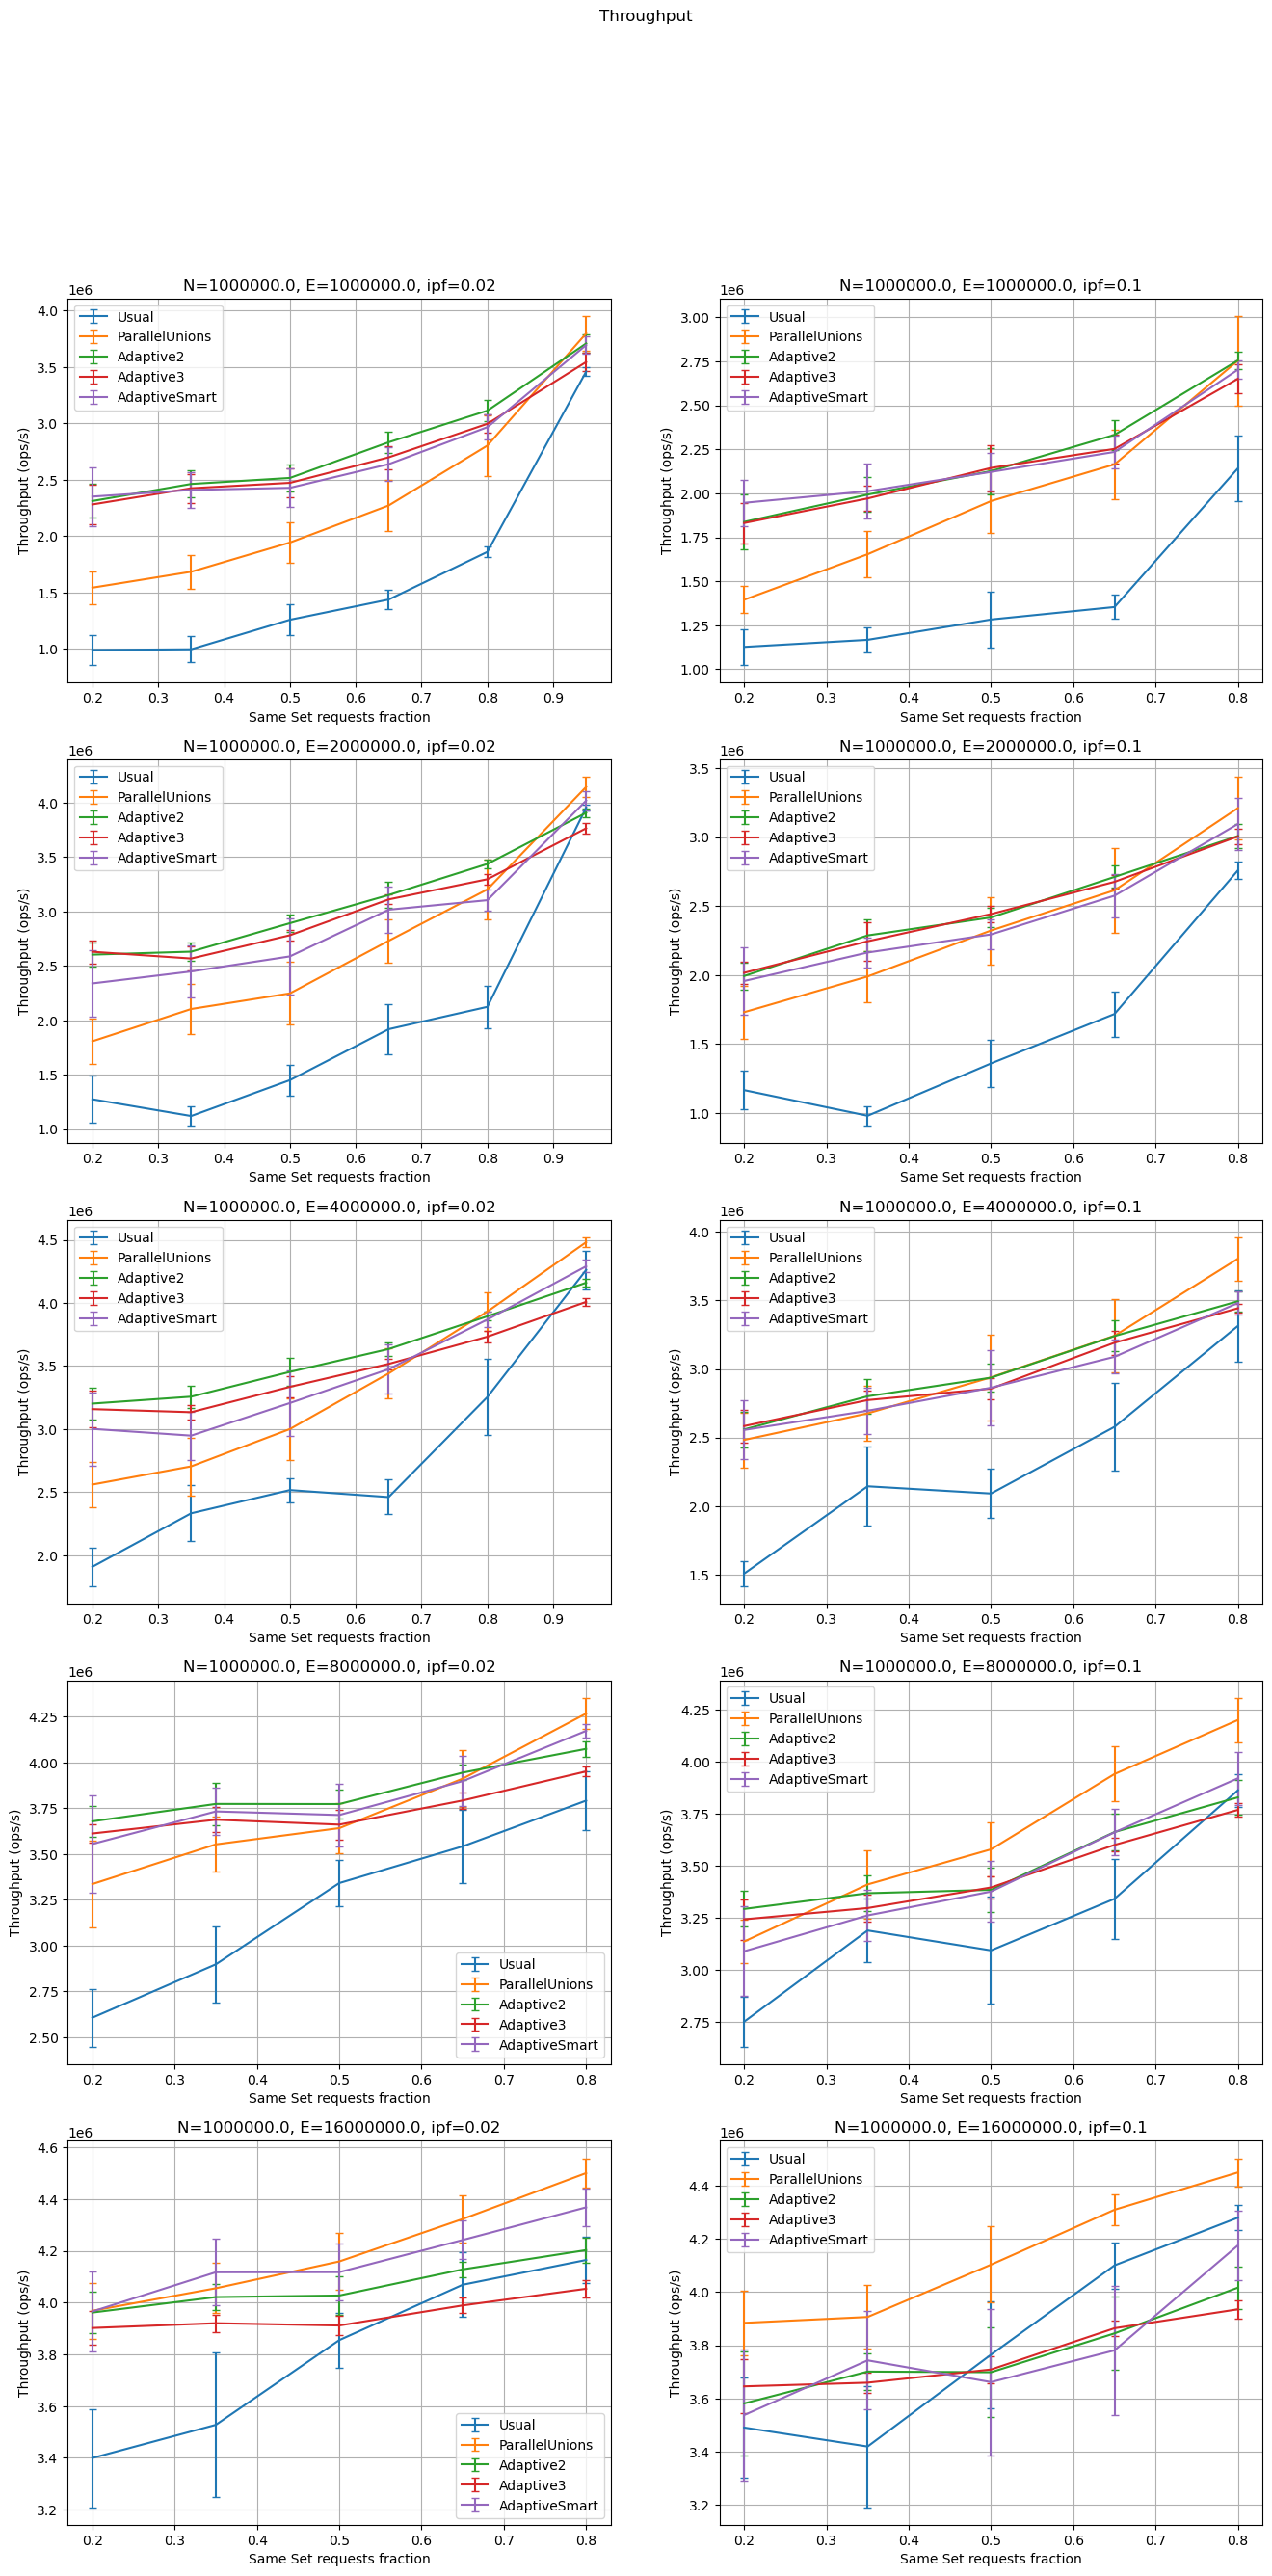

In [9]:
# d1 = pd.read_csv("measurements/out-old6.csv")
# d1 = d1[d1["interpairFraction"] < 0.5]
# d2 = pd.read_csv("measurements/out-old8.csv")
data = pd.concat([
    pd.read_csv("measurements/out-new.csv")
]).drop("shuffle", axis=1)
# d3 = d3[d3["DSU"].str.contains('2') | d3["DSU"].str.contains('3')]
# data = pd.concat([d1, d2])
# data = data[data["E"] < 60000000]
data = data.sort_values(by='E', kind='stable')
plot_thrpt(data, "ssf", "DSU", strip_subtype(halfing_dsus), nc=2)

# Metrics

In [9]:
def prod_united(rows):
    res = rows.reset_index(inplace=False).loc[1].copy()
    rows = rows.set_index("Metric")
    score = rows.loc["cross_node_write"]["Score"] + rows.loc["cross_node_read"]["Score"] + rows.loc["global_data_read_write"]["Score"]
    err = rows.loc["cross_node_write"]["Score Error"] + rows.loc["cross_node_read"]["Score Error"] + rows.loc["global_data_read_write"]["Score Error"]
    res["Metric"] = "united_cross_node_access"
    res["Score"] = score
    res["Score Error"] = err
    res = res.drop("index")
    return res

def good_dsus(x):
    s = x['DSU'].str
    return x[s.contains('halfing') & (s.contains('Adaptive2') | s.contains('Adaptive3') | s.contains('Parallel'))]

met = pd.read_csv('measurements/out-new-with-metrics.csv').sort_values(axis=0, by="E", kind='stable')

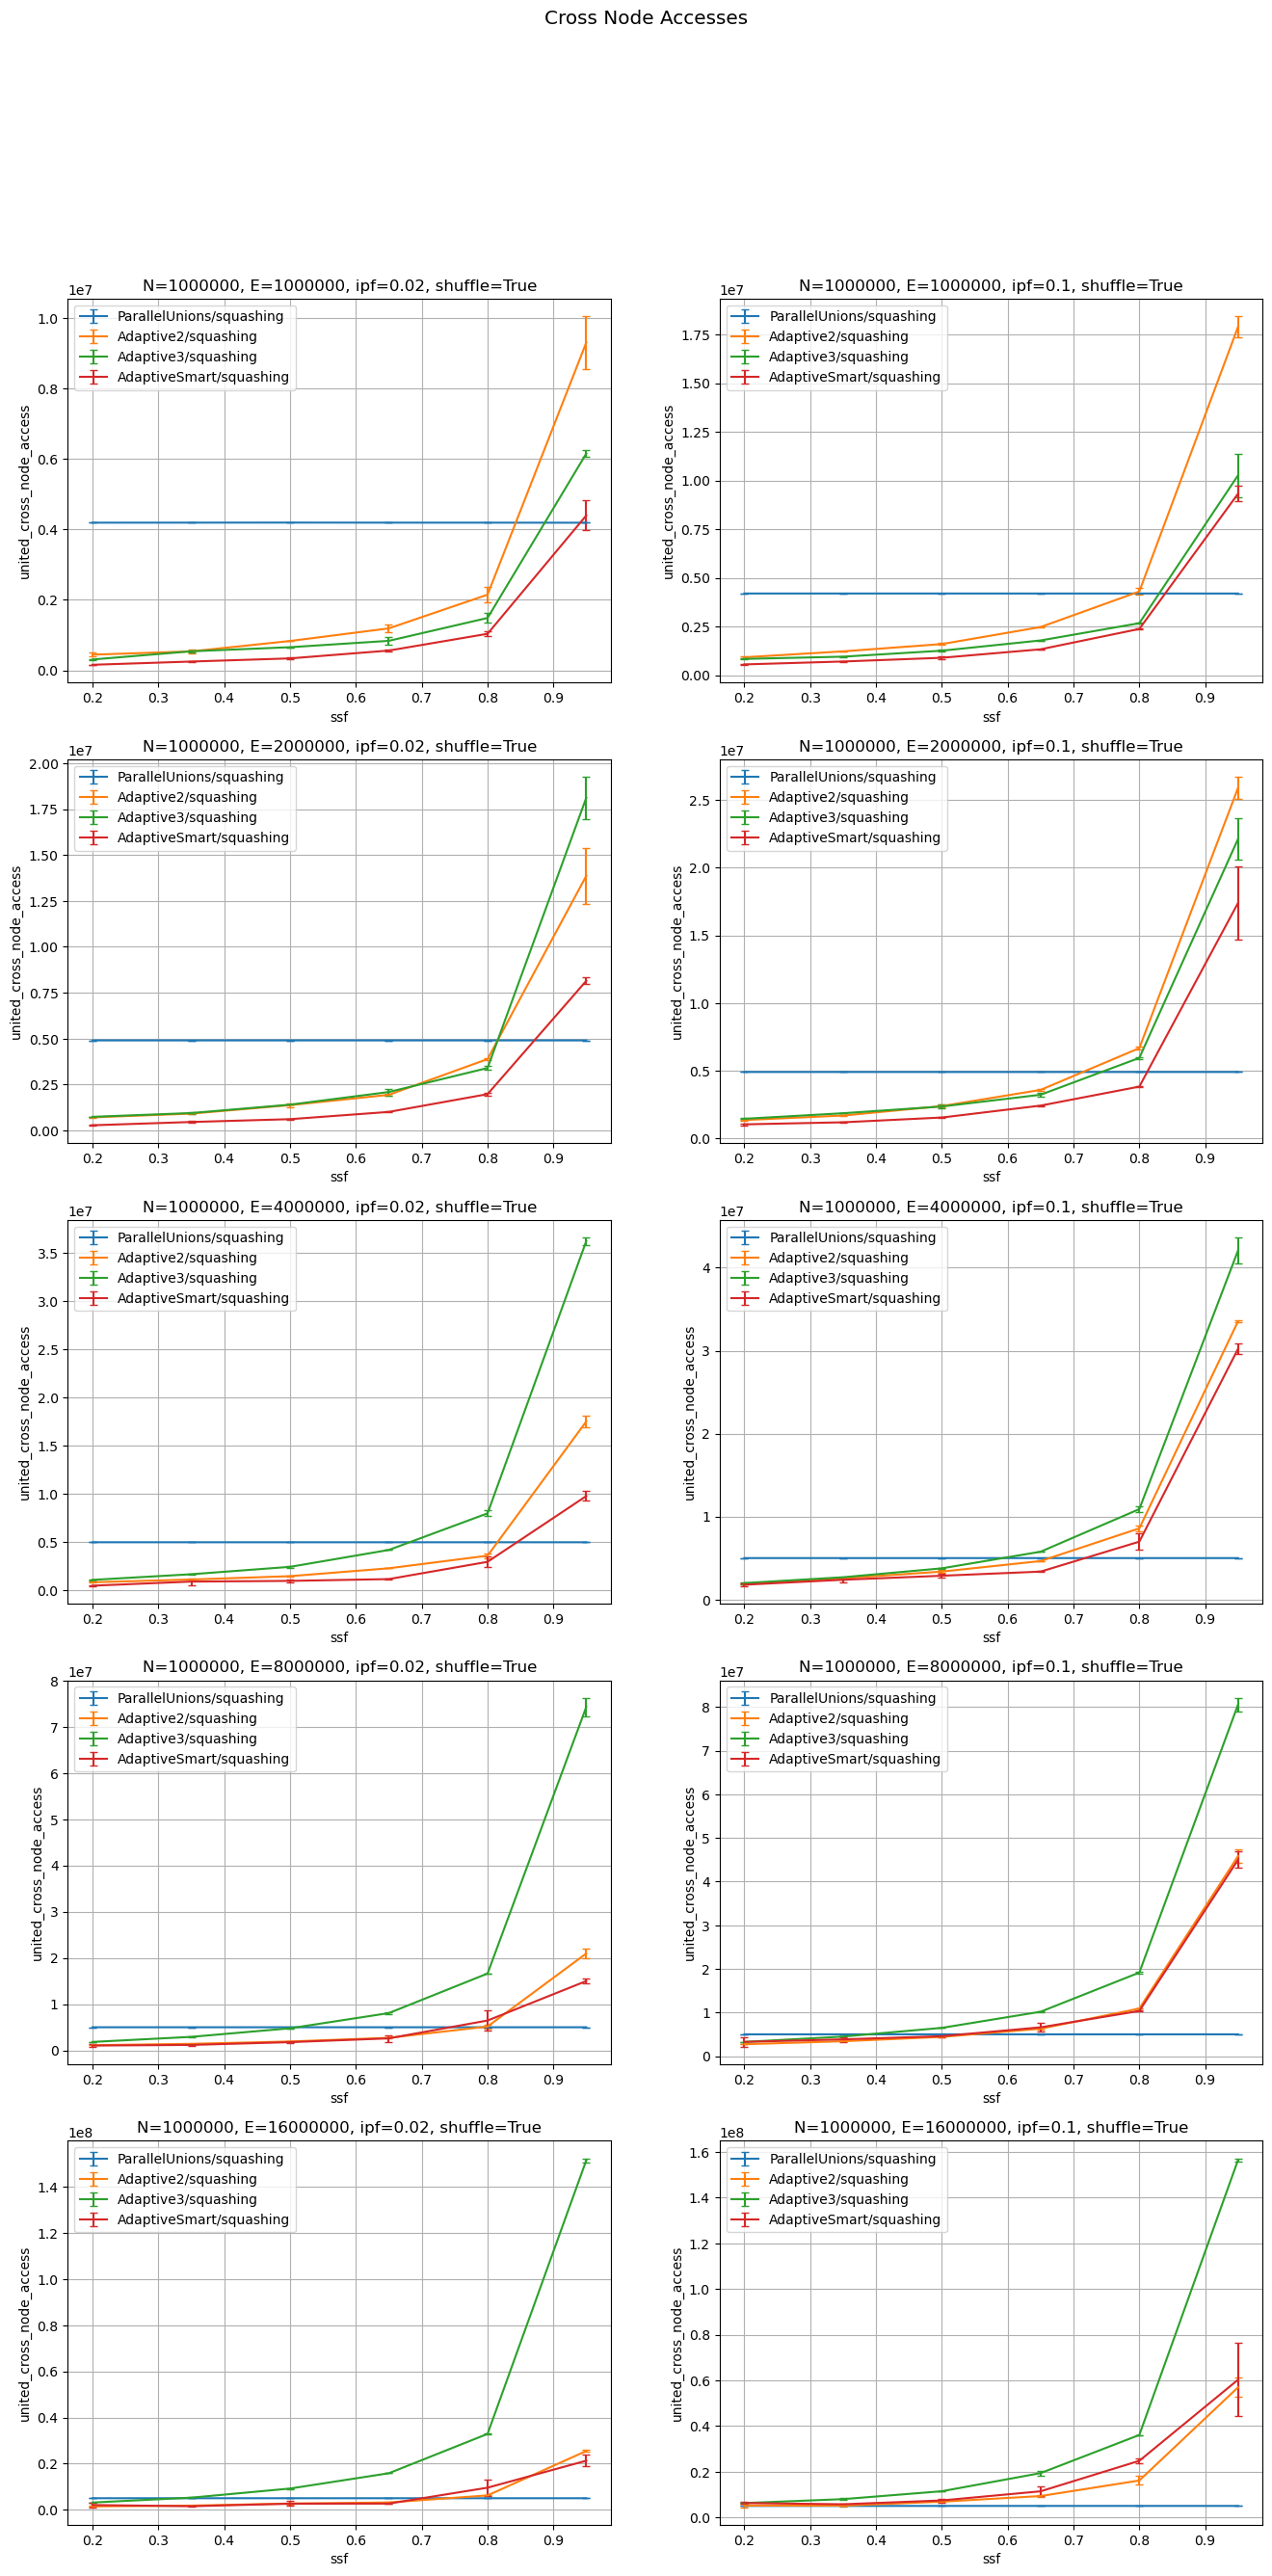

In [12]:
m2 = emit_metric(met, prod_united)
m2 = m2
plot_met(m2, "united_cross_node_access", "ssf", "DSU", squashing_dsus_nu, nc=2)
plt.suptitle("Cross Node Accesses", fontsize='x-large');

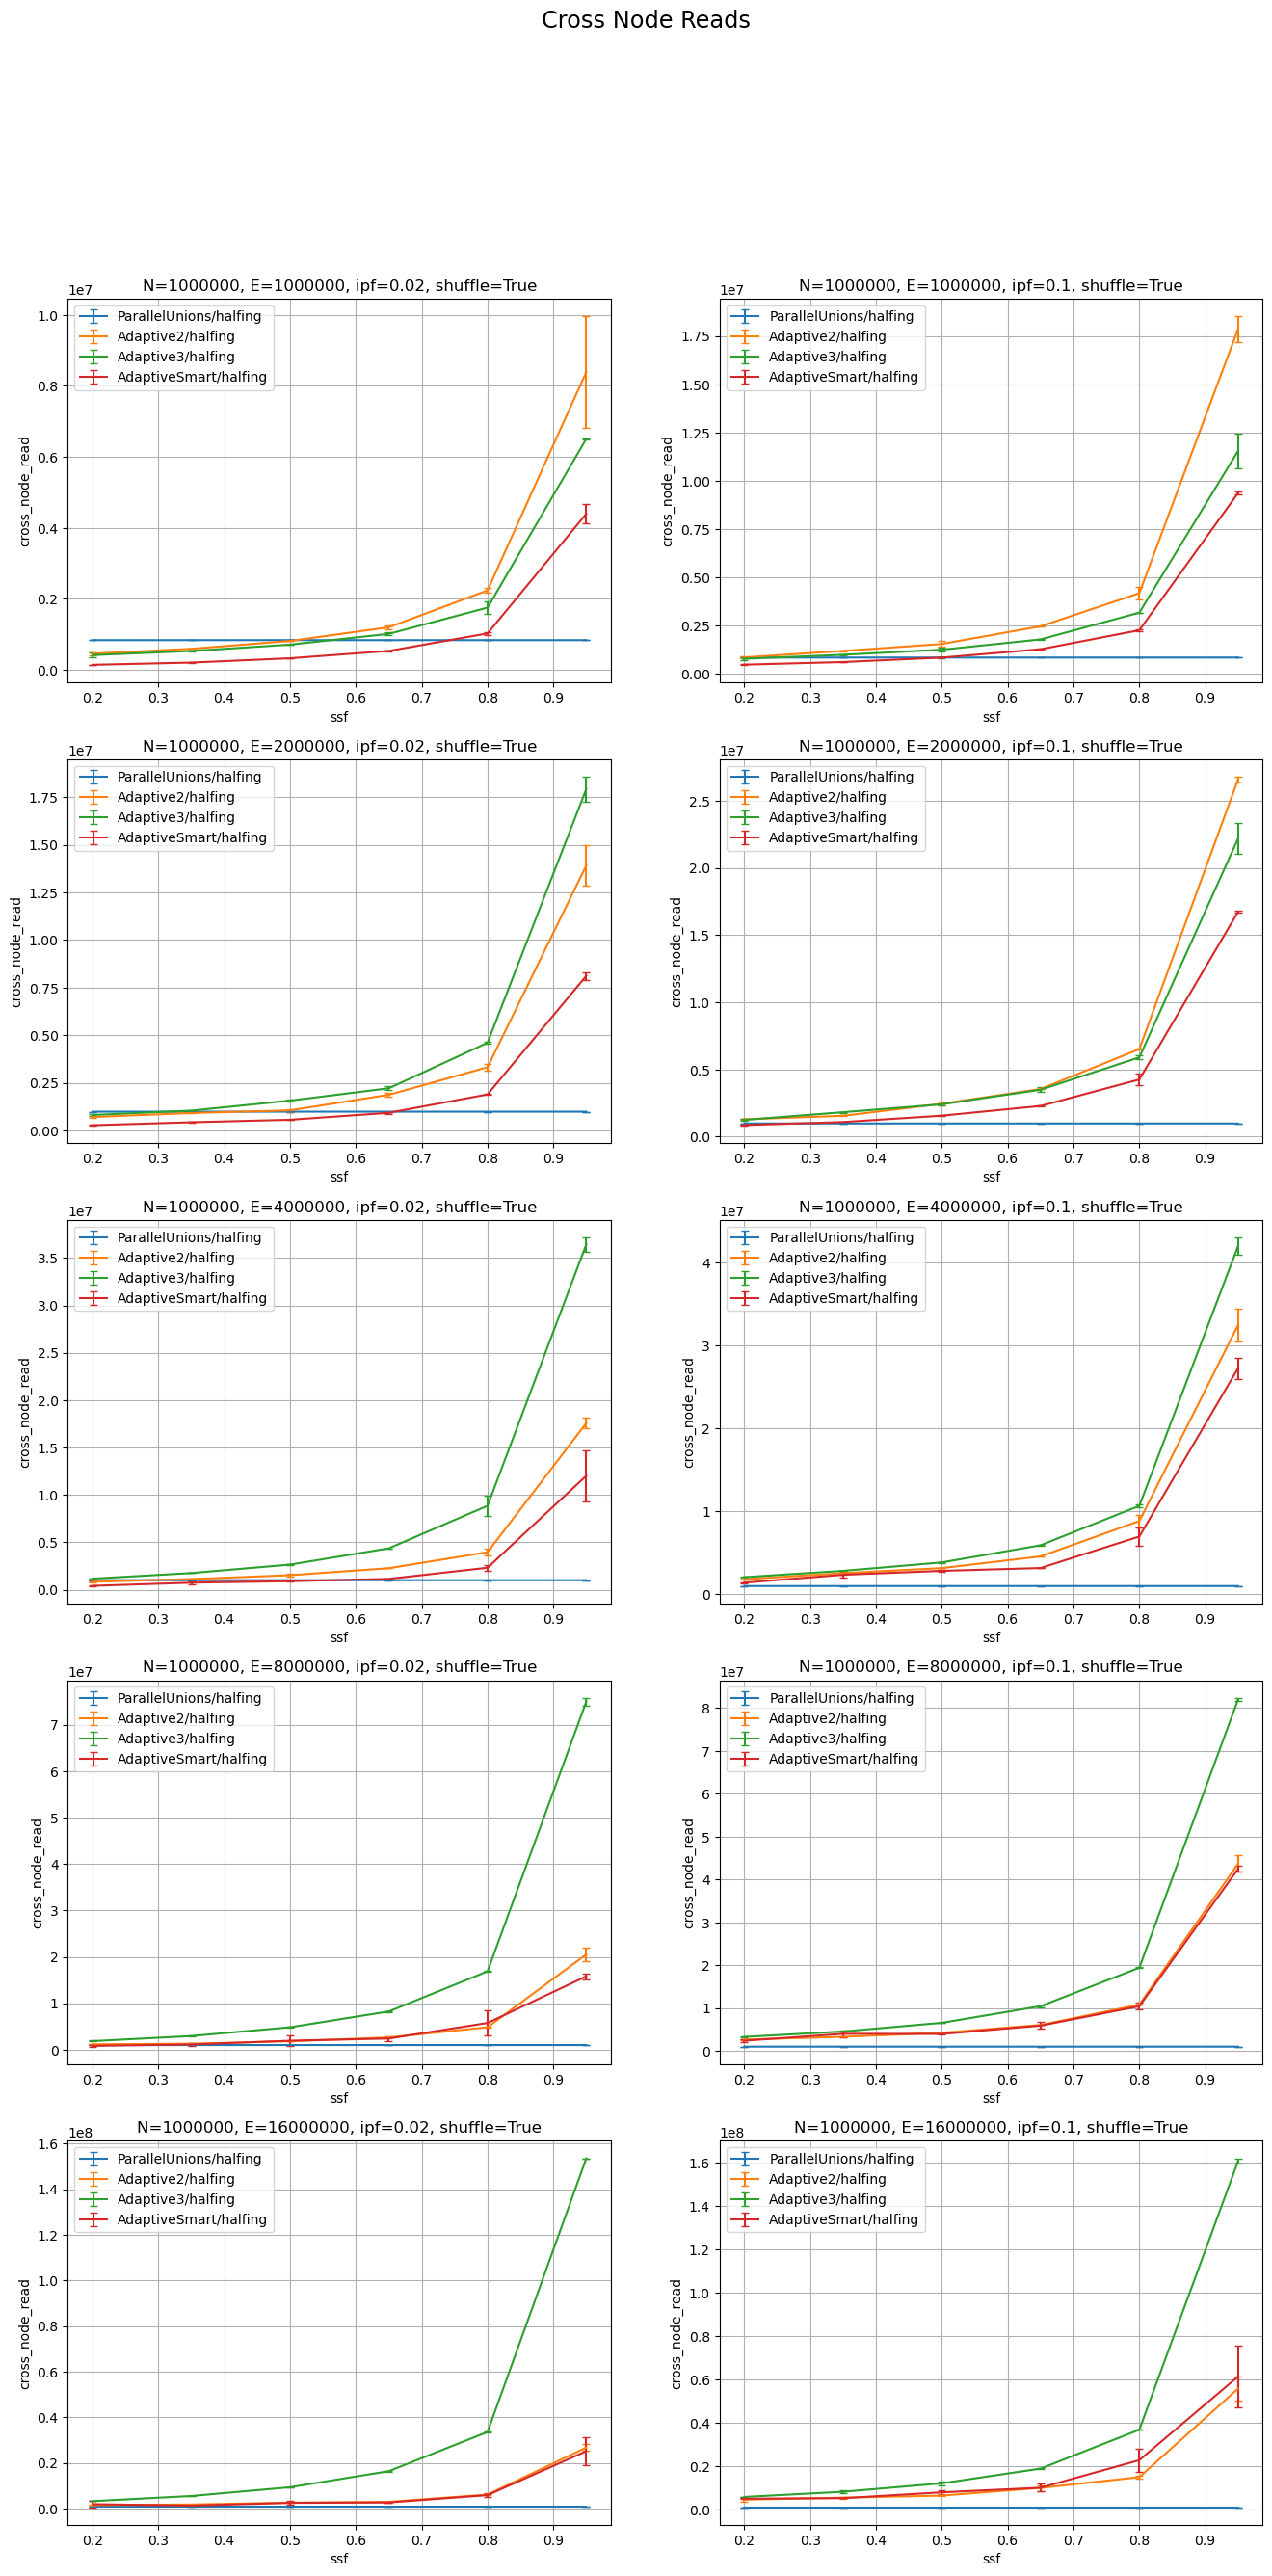

In [12]:
plot_met(met, "cross_node_read", "ssf", "DSU", halfing_dsus_nu, nc=2)
plt.suptitle("Cross Node Reads", fontsize='xx-large');

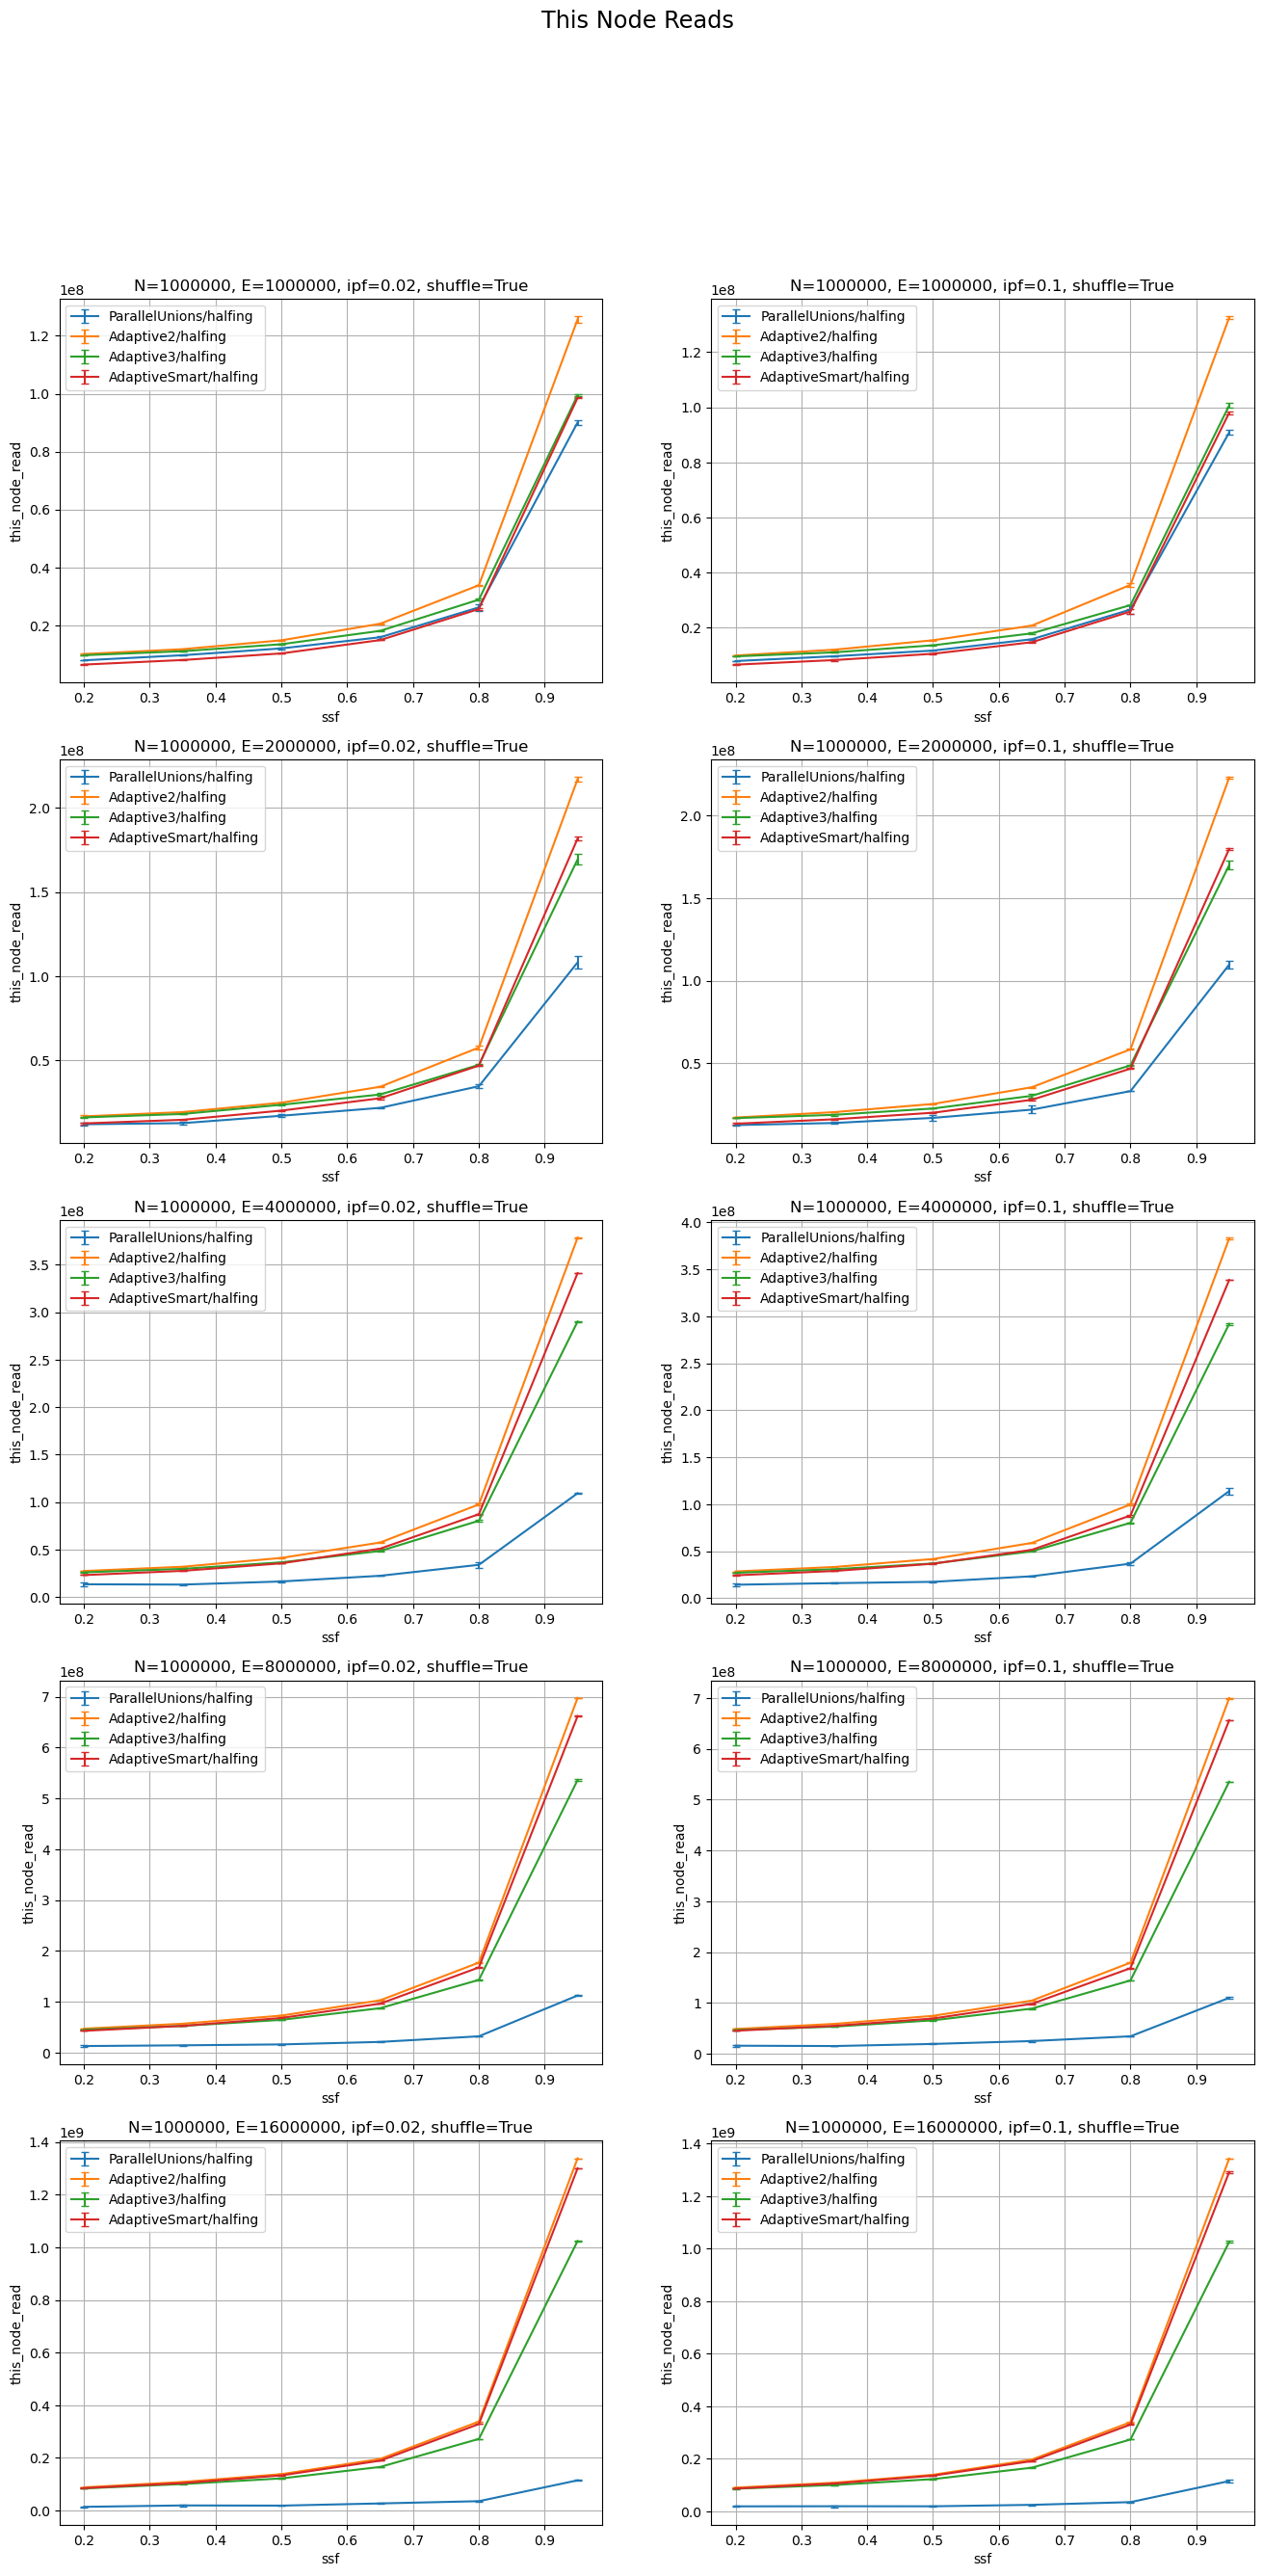

In [13]:
plot_met(met, "this_node_read", "ssf", "DSU", halfing_dsus_nu, nc=2)
plt.suptitle("This Node Reads", fontsize='xx-large');

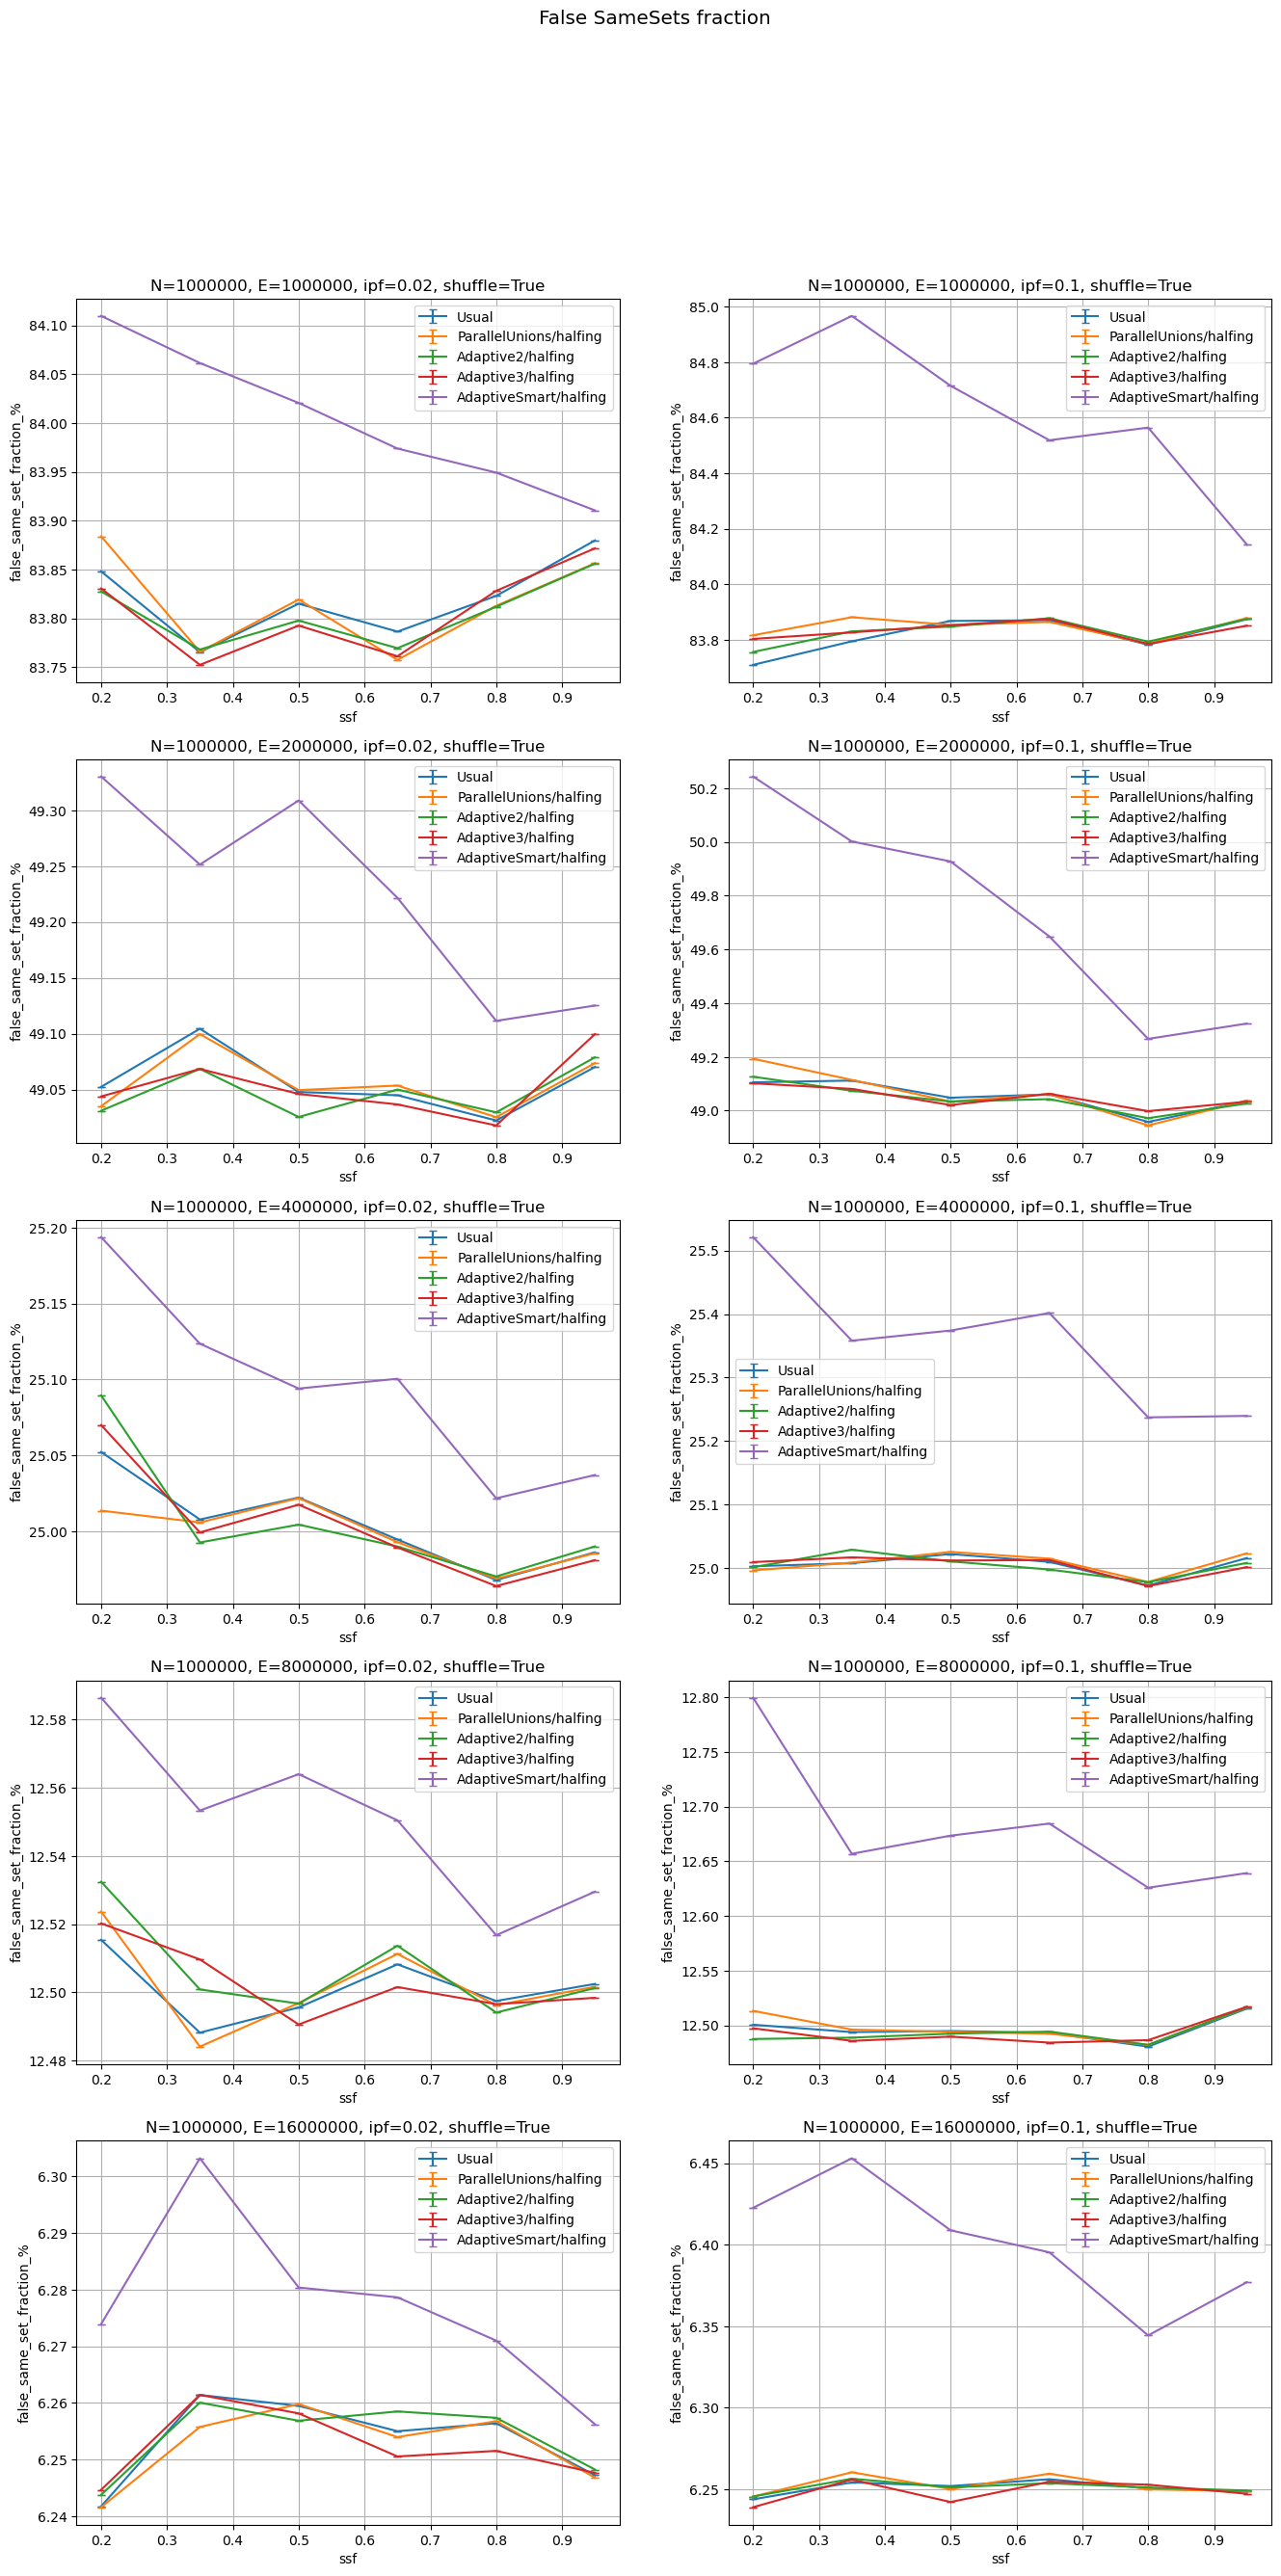

In [14]:
def prod_same_set_false(rows):
    res = rows.reset_index(inplace=False).loc[1].copy()
    rows = rows.set_index("Metric")
    score = rows.loc["same_set_requests_false"]["Score"] / (rows.loc["same_set_requests_false"]["Score"] + rows.loc["same_set_requests_true"]["Score"]) * 100
    res["Metric"] = "false_same_set_fraction_%"
    res["Score"] = score
    res["Score Error"] = 0.0
    res = res.drop("index")
    return res
m2 = emit_metric(met, prod_same_set_false)
plot_met(m2, "false_same_set_fraction_%", "ssf", "DSU", halfing_dsus, nc=2)
plt.suptitle("False SameSets fraction", fontsize='x-large');

# Experiments with stages

- 1<sup>st</sup> stage: only unions ($Parameter Set=0,1 \rightarrow E=4\,000\,000$; $Parameter Set=2,3 \rightarrow E=16\,000\,000$)
- 2<sup>nd</sup> stage: same-sets without compaction
- 3<sup>rd</sup> stage: same-sets with compaction

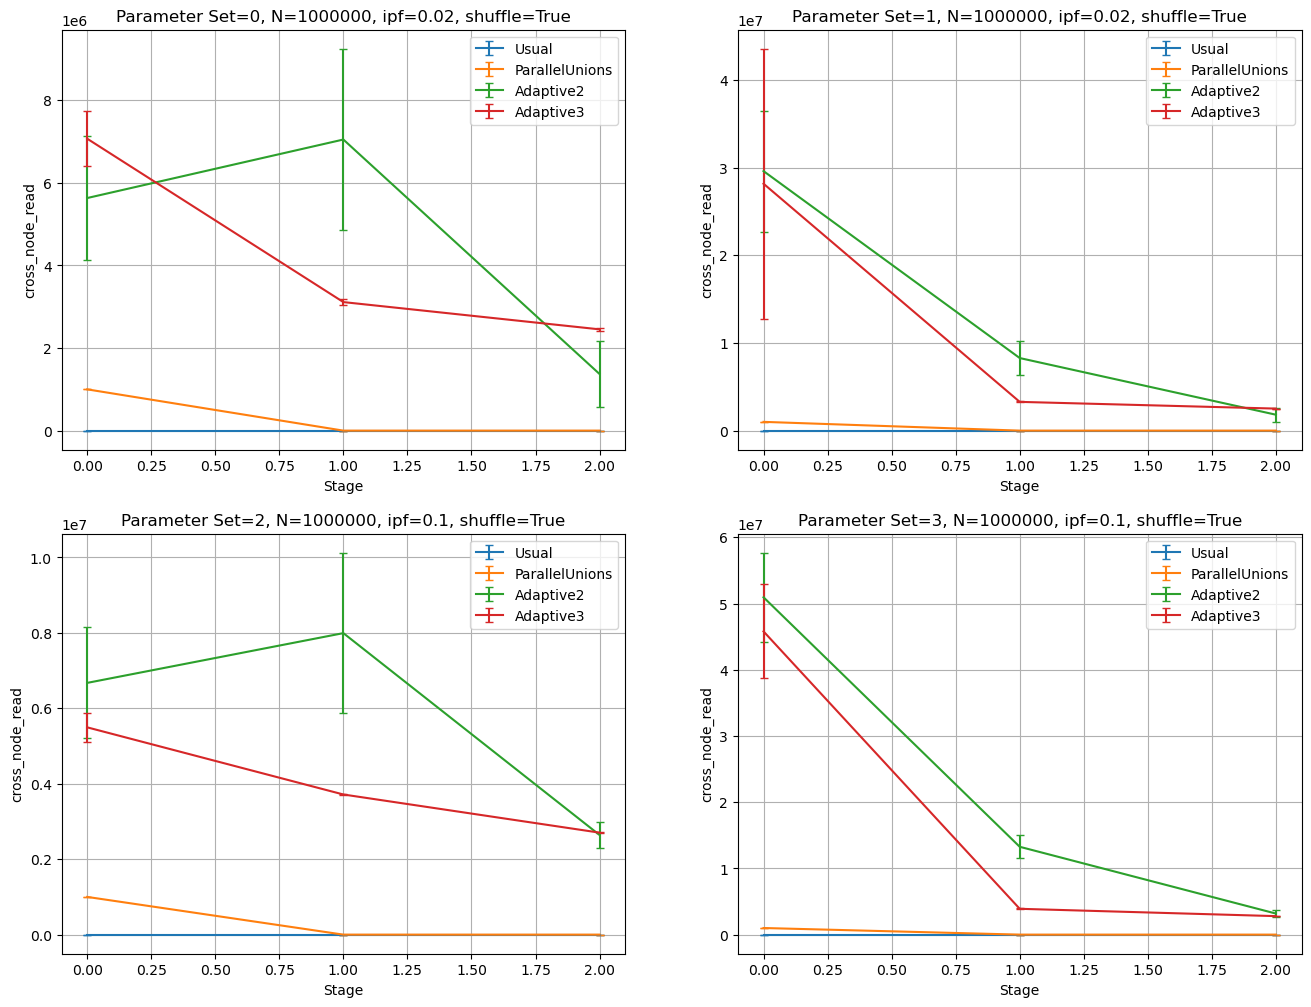

In [15]:
data = pd.read_csv("measurements/cohists-out-staged.csv")
plot_met(data, "cross_node_read", "Stage", "DSU", cut_field(["E", "ssf"], strip_subtype(halfing_dsus)), nc=2)

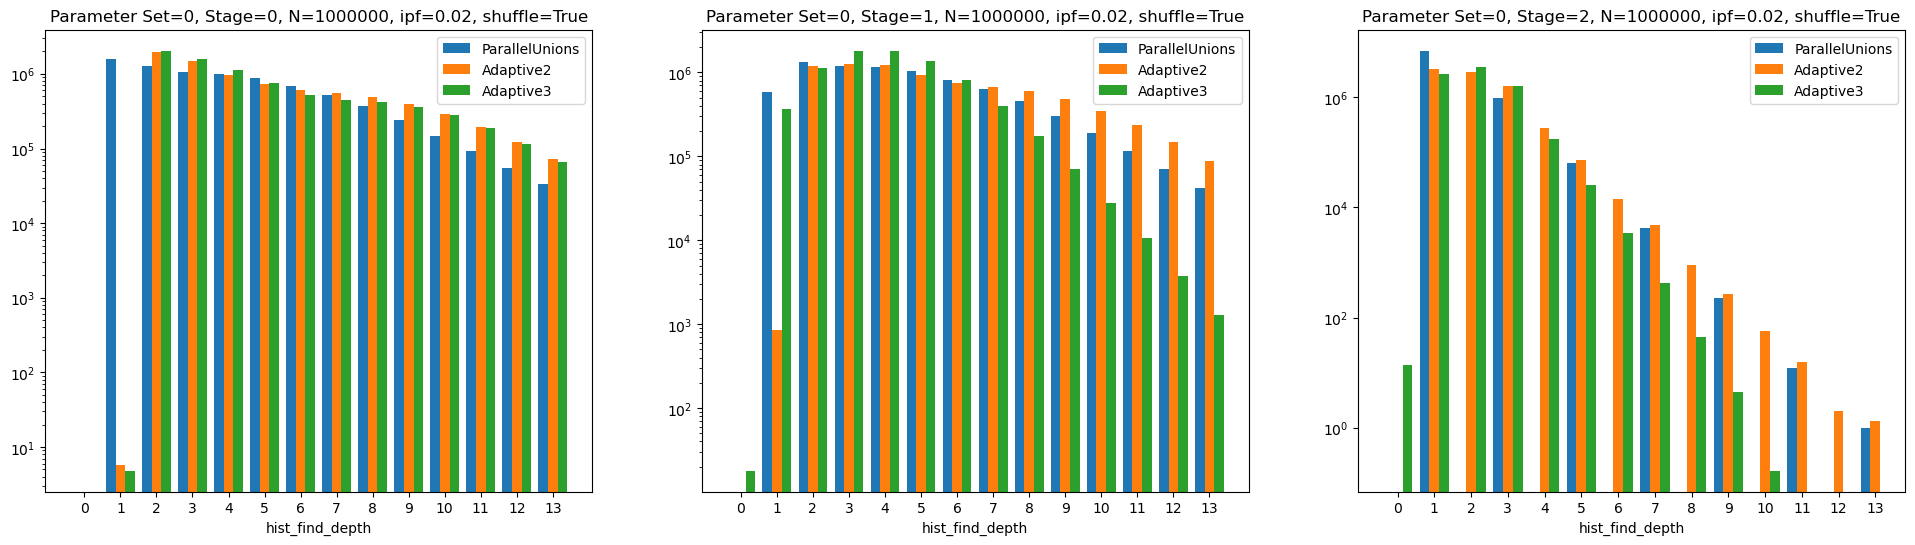

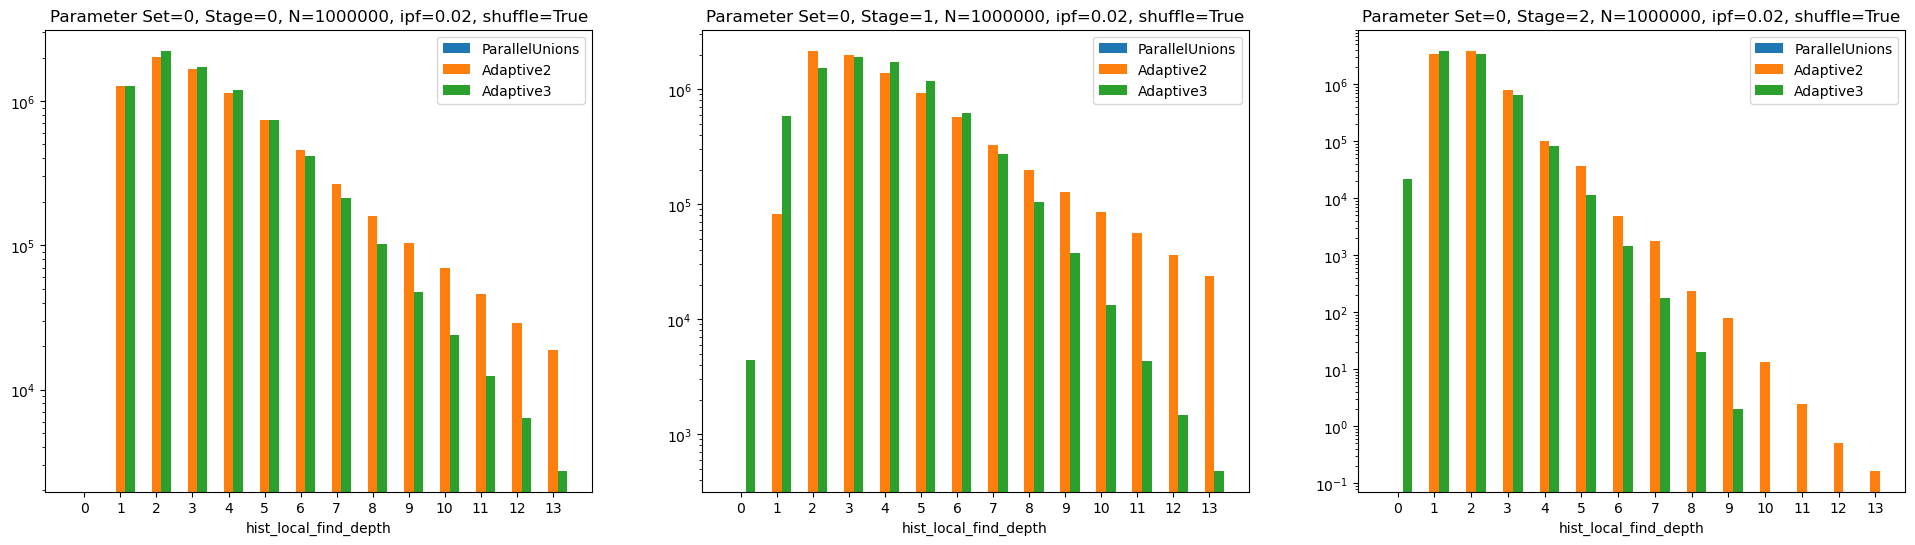

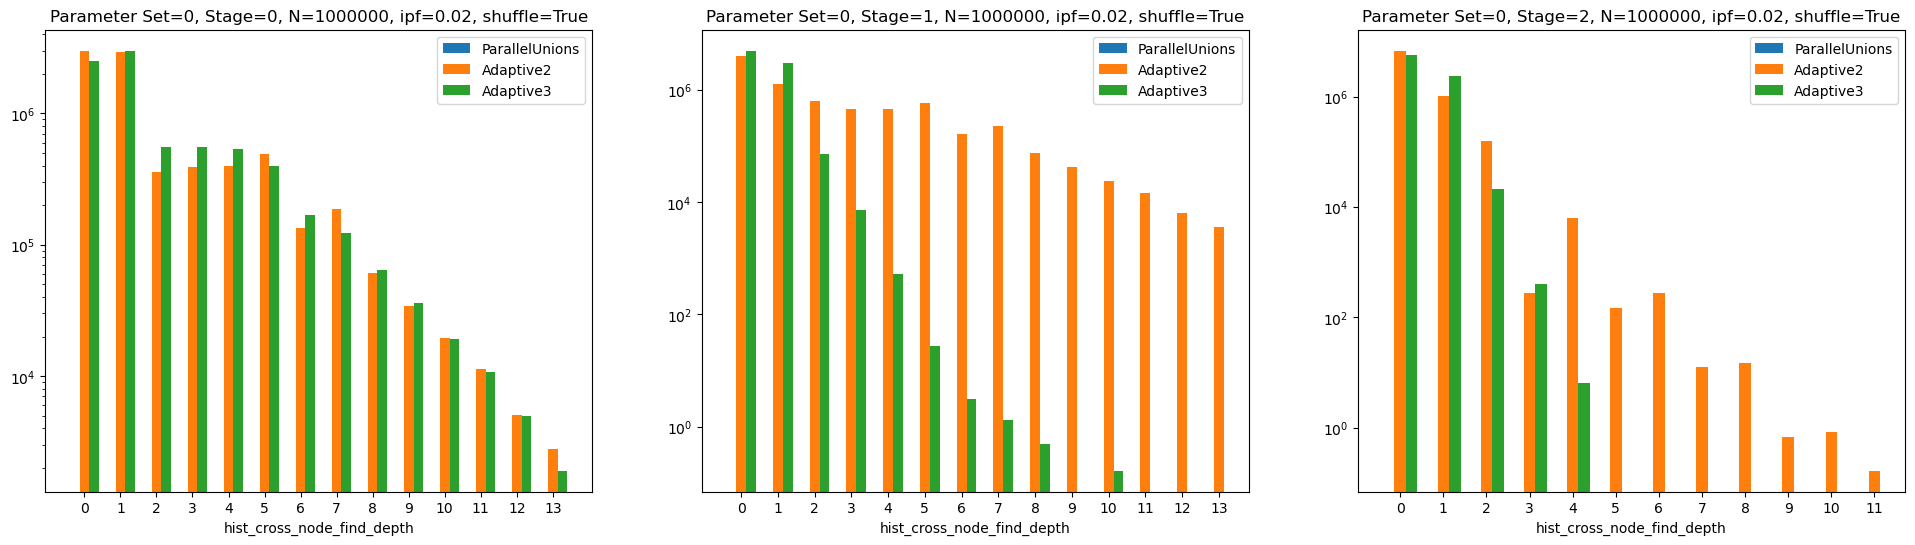

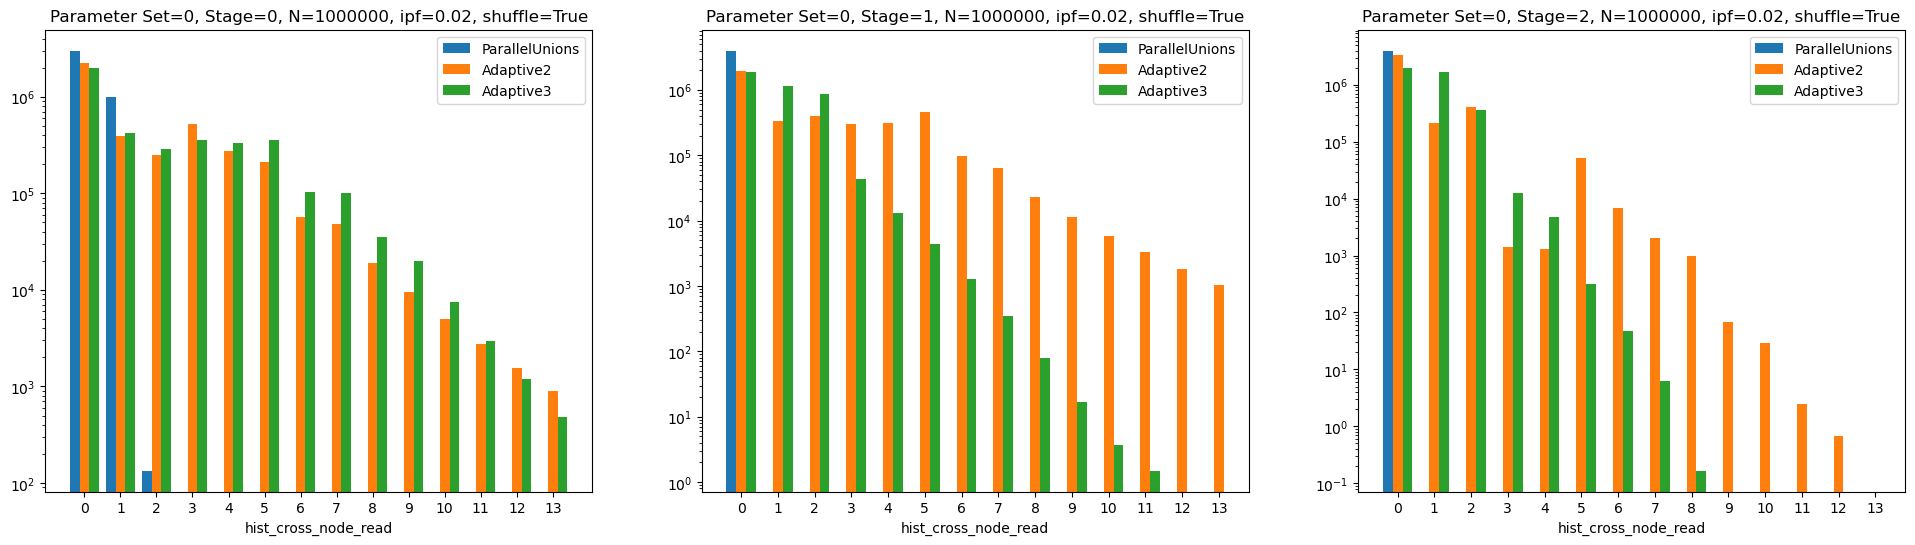

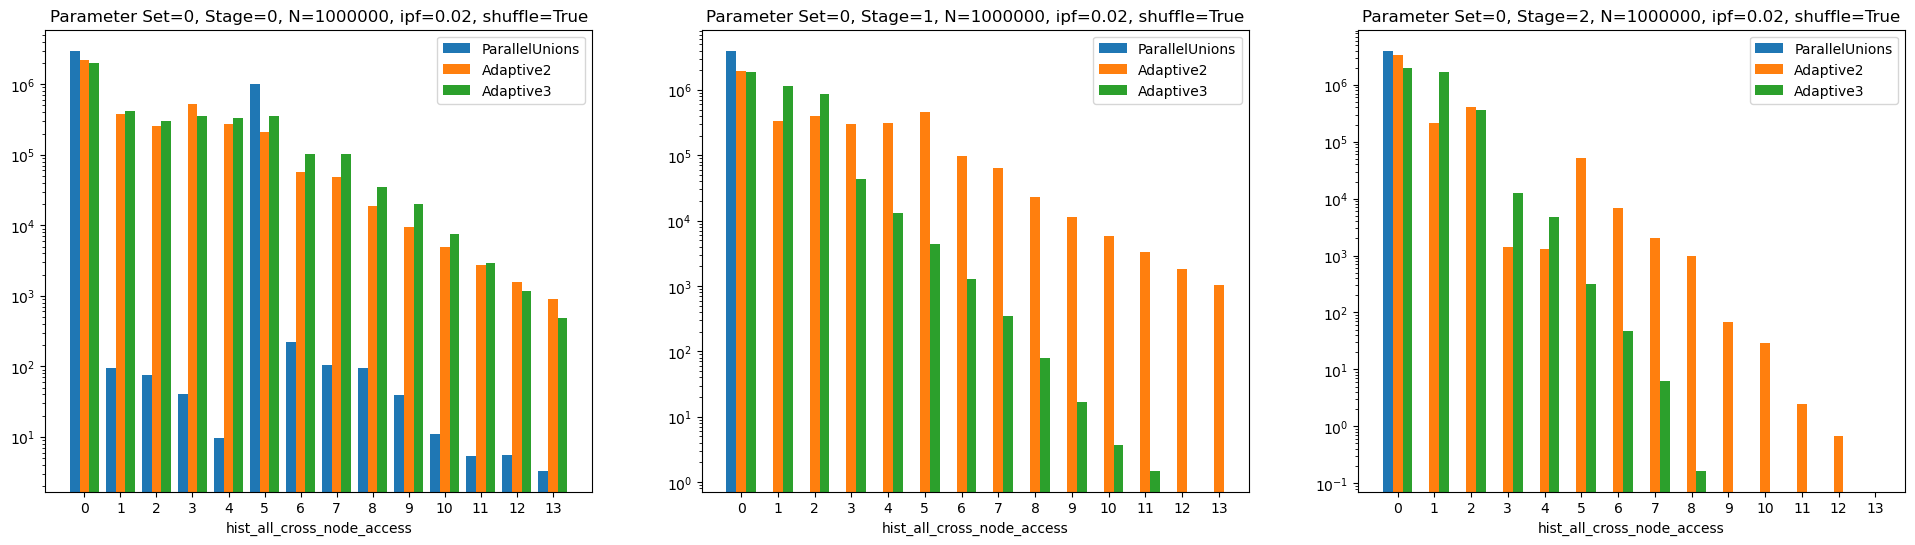

In [16]:
met = pd.read_csv('measurements/cohists-out-staged.csv')
hmet = pd.read_csv('measurements/hists-out-staged.csv')
met = met[met["Parameter Set"] == 0]
plot_hist(met, hmet, 'hist_find_depth', "DSU", cut_field(["E", "ssf"], strip_subtype(halfing_dsus_nu)), nc=3)
plot_hist(met, hmet, 'hist_local_find_depth', "DSU", cut_field(["E", "ssf"], strip_subtype(halfing_dsus_nu)), nc=3)
plot_hist(met, hmet, 'hist_cross_node_find_depth', "DSU", cut_field(["E", "ssf"], strip_subtype(halfing_dsus_nu)), nc=3)
plot_hist(met, hmet, 'hist_cross_node_read', "DSU", cut_field(["E", "ssf"], strip_subtype(halfing_dsus_nu)), nc=3)
plot_hist(met, hmet, 'hist_all_cross_node_access', "DSU", cut_field(["E", "ssf"], strip_subtype(halfing_dsus_nu)), nc=3)

# Histograms

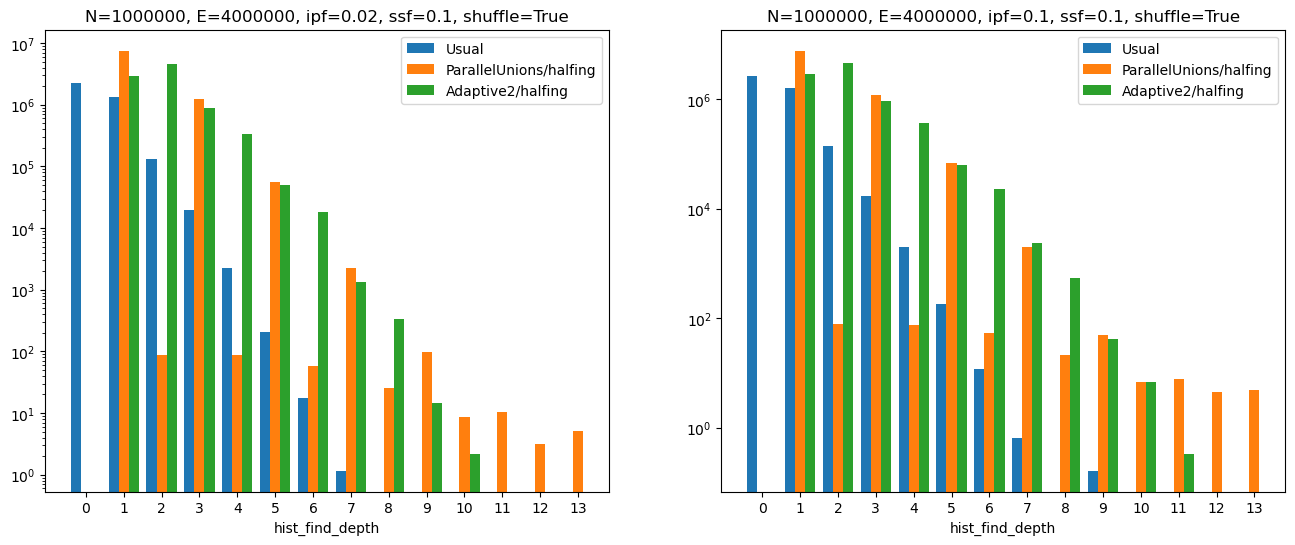

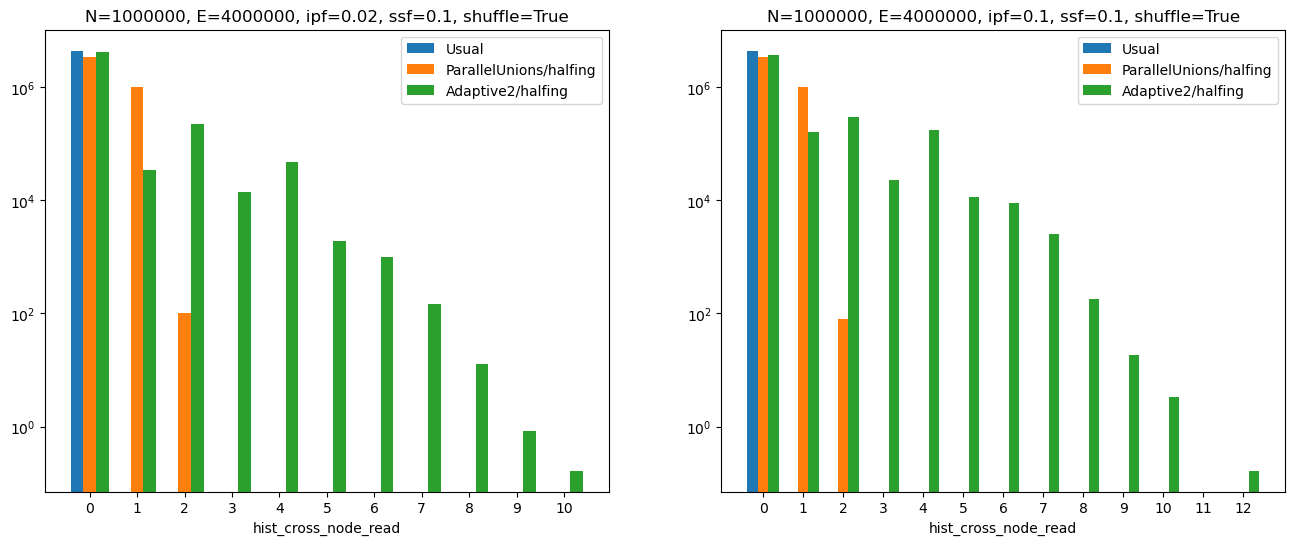

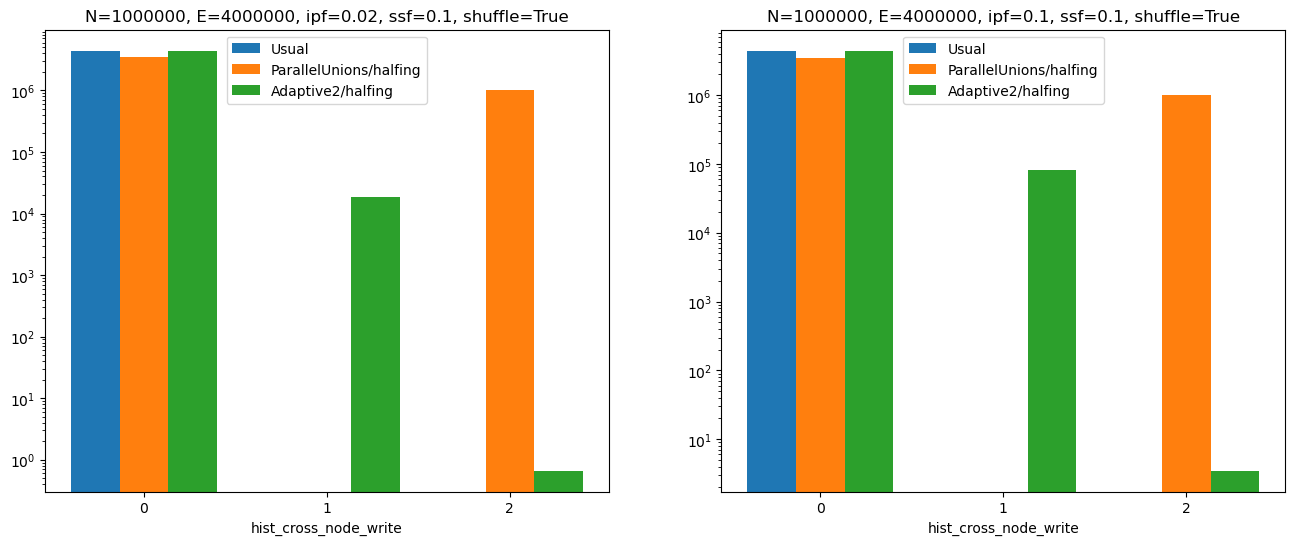

In [17]:
met = pd.read_csv('measurements/cohist-out.csv')
hmet = pd.read_csv('measurements/hists-out.csv')
plot_hist(met, hmet, 'hist_find_depth', "DSU", halfing_dsus, nc=2)
plot_hist(met, hmet, 'hist_cross_node_read', "DSU", halfing_dsus, nc=2)
plot_hist(met, hmet, 'hist_cross_node_write', "DSU", halfing_dsus, nc=2)